In [1]:
from os.path import join
import scipy
import os
import numpy as np
from my_utils.loader import load_event_features
from sklearn.ensemble import IsolationForest, RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
import pandas as pd
import matplotlib.pyplot as plt

import re
import umap

In [2]:
def sorted_nicely(l):
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)] 
    return sorted(l, key = alphanum_key)

In [3]:
def load_dataset(path_ou, path_gazetime, path_pupil):
    global_data_fix = []
    global_data_sac = []
    paths_ou = sorted_nicely(os.listdir(path_ou))
    paths_gazetime = sorted_nicely(os.listdir(path_gazetime))
    paths_pupil = sorted_nicely(os.listdir(path_pupil))
    sias_df = pd.read_excel('./osf/Questionnaires.xlsx')
    sias_df = sias_df.drop(sias_df.index[24]) # Deleting three subjects because not suitable
    sias_df = sias_df.drop(sias_df.index[19]) 
    sias_df = sias_df.drop(sias_df.index[8])
    sias_df['UCS_pain_post']= pd.to_numeric(sias_df['UCS_pain_post'])
    sias_df = sias_df[sias_df['UCS_pain_post']>2] # Deleting subjects with UCS_pain_post less than 2
    sias_score = sias_df.iloc[:, 1:21]
    sias_score = sias_score.apply(pd.to_numeric)
    sias_score['SIAS05'] = [4]*43 - sias_score['SIAS05']
    sias_score['SIAS09'] = [4]*43 - sias_score['SIAS09']
    sias_score['SIAS11'] = [4]*43 - sias_score['SIAS11']
    sias_score = sias_score.sum(axis=1)
    sias_df['score'] = sias_score
    sias_df['anxiety'] = sias_score >= 30
    sias_df = sias_df[['VP', 'score', 'anxiety']]
    
    # Mapping subject ids to their label   
    map_sias = { x[1]['VP'] : x[1]['score']  for x in sias_df.iterrows() } 
    map_is_anxious = { x[1]['VP'] : x[1]['anxiety']  for x in sias_df.iterrows() }
    subs_considered = 0
    paths_ou.remove('event_features_11.npy')
    paths_ou.remove('event_features_20.npy')
    paths_ou.remove('event_features_25.npy')
    paths_ou.remove('event_features_42.npy')
    paths_gazetime.remove('gaze_data_timeLook011.asc.npy')
    paths_gazetime.remove('gaze_data_timeLook020.asc.npy')
    paths_gazetime.remove('gaze_data_timeLook025.asc.npy')
    paths_gazetime.remove('gaze_data_timeLook042.asc.npy')
    for index, file in enumerate(paths_ou):
        fix_data, sac_data, stim_fix, stim_sac = load_event_features( join(path_ou, file), 
                                                                      join(path_gazetime, paths_gazetime[index]), 
                                                                      join(path_pupil, paths_pupil[index]) )
        subject_id = int(file.split("_")[2].split(".")[0])
        label = map_sias.get(subject_id, -1)
        
        curr_label_f = np.ones([fix_data.shape[0], 1]) * label
        curr_label_s = np.ones([sac_data.shape[0], 1]) * label
        
        curr_subject_id_f = np.ones([fix_data.shape[0], 1]) * subject_id
        curr_subject_id_s = np.ones([sac_data.shape[0], 1]) * subject_id
        
        fix_data = np.hstack([curr_subject_id_f, curr_label_f, stim_fix, fix_data])
        sac_data = np.hstack([curr_subject_id_s, curr_label_s, stim_sac, sac_data])
        if label != -1: # I consider the subject only if it is in the selected 44
            global_data_fix.append(fix_data)
            global_data_sac.append(sac_data)
            subs_considered += 1
        else:
            print('Subject '+str(subject_id)+' not suitable')
    data_fix = np.vstack(global_data_fix)
    data_sac = np.vstack(global_data_sac)
    print('\nLoaded ' + str(subs_considered) + ' subjects...')
    return data_fix, data_sac

In [4]:
def get_features(data, config='all_features', typ='sac'):
    n_classic_features = 1 if typ=='fix' else 3
    n_pupil_features = 2
    n_tot_features = 15 if typ=='fix' else 17
    if config == 'all_features':
        return data[:, 3: ]
    elif config == 'classic_features':
        return data[:, 3 + n_tot_features - n_classic_features - n_pupil_features : 3 + n_tot_features - n_pupil_features ]
    elif config == 'pupil_features':
        return data[:, 3 + n_tot_features - n_pupil_features: ]
    elif config == 'ou_features':
        return data[:, 3: 3 + n_tot_features - n_classic_features - n_pupil_features]

MAIN ---------------------------------------------------------------------

In [5]:
dataset_name = 'Reutter_OU_posterior_VI'
models_regression = [ #'GPR',
                      #SVR( C=1000, kernel='rbf', gamma=0.002),
                      RandomForestRegressor(),
                      MLPRegressor(hidden_layer_sizes=(100, 50, 25))
                    ]

In [6]:
directory_ou = join(join('features', dataset_name), 'train')
directory_gazetime = './osf/gazetime/'
directory_pupil = './osf/pupil_data/'

In [7]:
data_fix, data_sac = load_dataset(directory_ou, directory_gazetime, directory_pupil)
map_ss_sias = {} # Mapping (subject, stimulus) to Social Anxiety of the subject


Loaded 43 subjects...


In [8]:
for x in data_fix[:, :3]:
    map_ss_sias[int(x[0])] = x[1]

In [9]:
map_ss_sias

{1: 19.0,
 2: 13.0,
 3: 30.0,
 4: 14.0,
 5: 24.0,
 6: 20.0,
 7: 25.0,
 8: 12.0,
 10: 12.0,
 12: 17.0,
 13: 12.0,
 14: 15.0,
 15: 16.0,
 16: 47.0,
 17: 18.0,
 18: 16.0,
 19: 16.0,
 21: 20.0,
 22: 20.0,
 23: 35.0,
 24: 17.0,
 26: 13.0,
 27: 25.0,
 28: 27.0,
 29: 13.0,
 30: 17.0,
 31: 18.0,
 32: 30.0,
 33: 14.0,
 41: 9.0,
 43: 33.0,
 44: 14.0,
 45: 15.0,
 46: 23.0,
 47: 18.0,
 48: 28.0,
 49: 20.0,
 50: 23.0,
 51: 10.0,
 52: 17.0,
 53: 14.0,
 54: 9.0,
 55: 35.0}

In [10]:
mean = np.mean(list(map_ss_sias.values()))
std = np.std(list(map_ss_sias.values()))

In [11]:
yf_ranges = []
ys_ranges = []

for x in data_fix[:, :3]:
    if x[1] < 30:
        yf_ranges.append(0)
    else:
        yf_ranges.append(1)

for x in data_sac[:, :3]:
    if x[1] < 30:
        ys_ranges.append(0)
    else:
        ys_ranges.append(1)

In [12]:
X_fix = get_features( data_fix , typ='fix')
ids_f = data_fix[:, 0] # Subjects' ids (fixations)
yf = data_fix[:, 1] # Labels (fixations)
stim_f = data_fix[:, 2]  # Stimulus' ids (fixations)

In [13]:
X_sac = get_features( data_sac, typ='sac')
ids_s = data_sac[:, 0] # Subjects' ids (saccades)
ys = data_sac[:, 1] # Labels (saccades)
stim_s = data_sac[:, 2] # Stimulus' ids (saccades)

In [14]:
standard_embedding_fix= umap.UMAP(random_state=42).fit_transform(X_fix, y = yf_ranges)

In [15]:
standard_embedding_sac= umap.UMAP(random_state=42).fit_transform(X_sac, y = ys_ranges)

/home/paolo/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


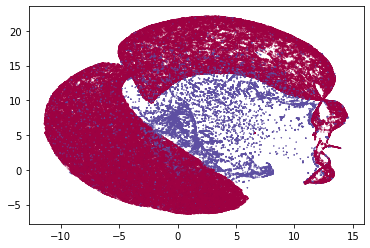

In [16]:
plt.scatter(standard_embedding_fix[:, 0], standard_embedding_fix[:, 1], s=0.1, cmap='Spectral', c= yf_ranges)

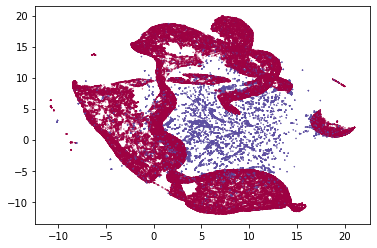

In [17]:
plt.scatter(standard_embedding_sac[:, 0], standard_embedding_sac[:, 1], s=0.1, cmap='Spectral',c= ys_ranges)